# Example usage of the ofset free koopman MPC

In [205]:
import sys
import os
import numpy as np
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a Dataset

In [206]:
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

In [207]:
# example simulation
sim_time = 500
Ts = 1
h1 = 1
h2 = 0.5
h0 = [h1, h2]
u = np.ones((sim_time,2))*0.5

sim = TwoTanks.simulate(h0, u, Ts)

### Step changes and simulation

In [208]:
constrains = np.array([[0, 0.5], [0, 1]])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constrains)

In [209]:
Ts = 1
h1 = 1
h2 = 0.5
u1 = steps[0,:]
u2 = steps[1,:]

sim = TwoTanks.simulate([h1, h2], steps, Ts)

In [210]:
# add noise to sim data

add_noise = True
if add_noise:
    # add noise to the simulation data
    # set random seed for reproducibility
    np.random.seed(42)
    noise = np.random.normal(0, 0.02, sim["Y"].shape)
    sim["Y"] += noise

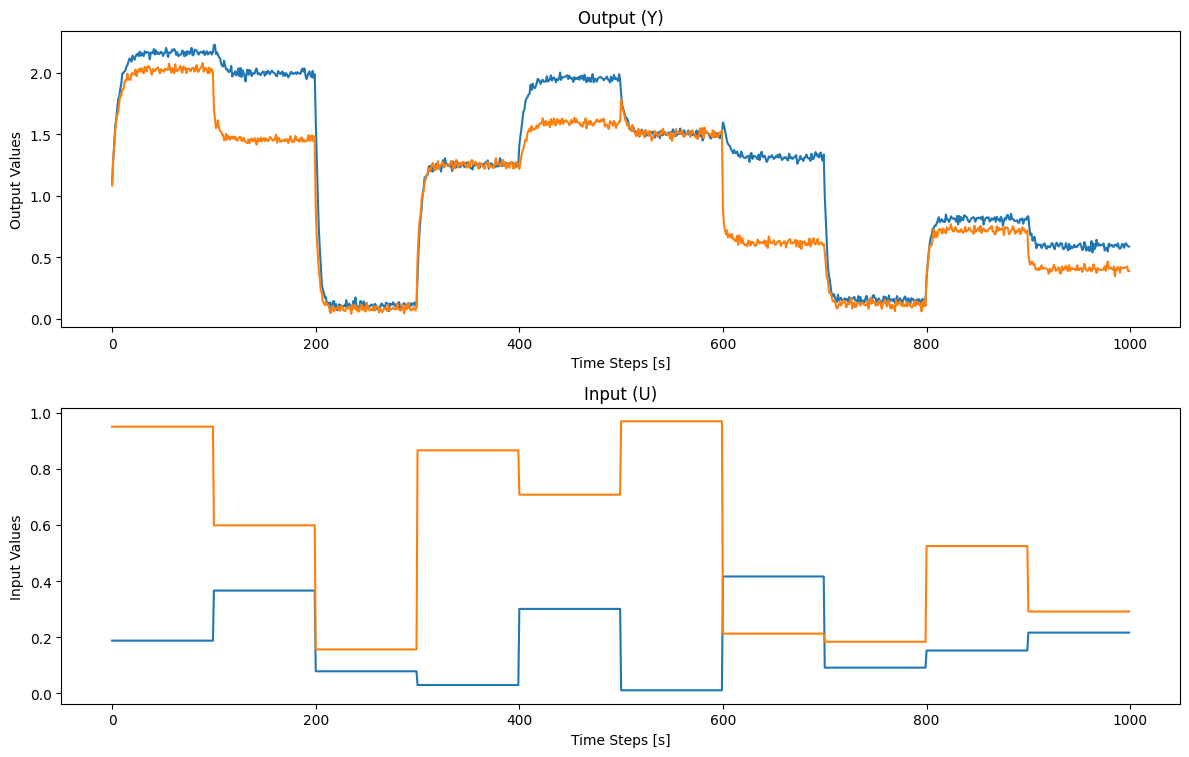

In [211]:
part = 1000

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(sim["Y"][:part])
plt.title("Output (Y)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Output Values")

plt.subplot(2, 1, 2)
plt.plot(sim["U"][:part])
plt.title("Input (U)")
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Values")

plt.tight_layout(rect=[0, 0, 1, 0.96])

## Preparing data for training koopman models

In [212]:
def get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU):
    
    ny = train_sim['Y'].shape[1]
    nu = train_sim['U'].shape[1]
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, ny)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, ny)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    
    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(1, nbatch*nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(1, nbatch*nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data_forC = {'Y': trainX, 'Y0': trainX[:, 0:1, :],
                 'U': trainU}

    return train_loader, dev_loader, test_data, train_data_forC

In [213]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

nsteps = 80   # number of prediction horizon steps in the loss function
bs = 80      # minibatching batch size

In [214]:
# fit and save scalers for scaling the data on train dataset
scaler = StandardScaler()
scaler.fit(train_sim['Y'])  
joblib.dump(scaler, '../data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train_sim['U'])
joblib.dump(scalerU, '../data/scalerU.pkl')


['../data/scalerU.pkl']

In [215]:
train_loader, dev_loader, test_data, train_data = get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU)

## Creating the model


In [216]:
# model parameters
nz = 10
ny = train_sim['Y'].shape[1]
nu = train_sim['U'].shape[1]

layers = [20,40,60]
layers_dec  = [60,40,20]

matrix_C = False

In [217]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [218]:
# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [219]:
# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [220]:
# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

In [221]:
# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [222]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

### Define Koopman system identification loss function terms

In [223]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

### Construct System learning problem

In [224]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [225]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

### Solve the problem

In [226]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    warmup=100,
    epochs=2000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [227]:
# train

best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0  train_loss: 29.60936164855957
epoch: 1  train_loss: 29.066225051879883
epoch: 2  train_loss: 28.549333572387695
epoch: 3  train_loss: 28.05160140991211
epoch: 4  train_loss: 27.565025329589844
epoch: 5  train_loss: 27.08255386352539
epoch: 6  train_loss: 26.597139358520508
epoch: 7  train_loss: 26.101573944091797
epoch: 8  train_loss: 25.589624404907227
epoch: 9  train_loss: 25.05501937866211
epoch: 10  train_loss: 24.49231719970703
epoch: 11  train_loss: 23.895750045776367
epoch: 12  train_loss: 23.259716033935547
epoch: 13  train_loss: 22.578304290771484
epoch: 14  train_loss: 21.847152709960938
epoch: 15  train_loss: 21.061410903930664
epoch: 16  train_loss: 20.21818733215332
epoch: 17  train_loss: 19.31351089477539
epoch: 18  train_loss: 18.342674255371094
epoch: 19  train_loss: 17.304176330566406
epoch: 20  train_loss: 16.197669982910156
epoch: 21  train_loss: 15.02456283569336
epoch: 22  train_loss: 13.794212341308594
epoch: 23  train_loss: 12.518869400024414
epoch: 24 

<All keys matched successfully>

### Saving model and evaluation of the training

In [228]:
# save model
torch.save(best_model, "../data/model_C_" + str(matrix_C) + ".pth")

# pull matrices
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
if matrix_C:
    C = f_y_inv.weight.detach().numpy()
    
elif not matrix_C:
    # get approximate C matrix from training data
    problem.nodes[3].nsteps = train_data['Y'].shape[1]
    train_outputs = problem.step(train_data)

    Y = train_data['Y'].reshape(-1, ny).detach().numpy()
    Z = train_outputs['x'][:,:-1,:].detach().numpy().reshape(-1, nz)
    rankZ = np.linalg.matrix_rank(Z)
    if rankZ < nz:
        print('Rank deficient Z matrix, can result in bad fitted C matrix!')
    C, residuals, rank, s = np.linalg.lstsq(Z, Y, rcond=None)
    C = C.T

else:
    raise ValueError('matrix_C must be boolean')

Rank deficient Z matrix, can result in bad fitted C matrix!


In [229]:
from numpy.linalg import matrix_rank

# Compute the controllability matrix
n_states = A.shape[0]
controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n_states)])

# Check the rank of the controllability matrix
controllability_rank = matrix_rank(controllability_matrix)

print(f"Controllability Matrix Rank: {controllability_rank}")
print(f"System is {'controllable' if controllability_rank == n_states else 'not controllable'}")

Controllability Matrix Rank: 10
System is controllable


In [230]:
# # Evaluate Jacobian for each latent state
# J_all = np.stack([
#     helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
#     for xi in x_train
# ])

# # Compute mean Jacobian
# C = np.mean(J_all, axis=0)
# print("Mean Jacobian J_mean:\n", C) # mean bias?

In [231]:
np.save('../data/A_C_' + str(matrix_C) + '.npy', A)
np.save('../data/B_C_' + str(matrix_C) + '.npy', B)
np.save('../data/C_C_' + str(matrix_C) + '.npy', C)

In [232]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [233]:
# do the prediction
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, ny).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz).T

In [234]:
pred_traj_C = np.dot(C, pred_x)

In [235]:
x_mean = np.mean(pred_x, axis=1, keepdims=True)
x_med = np.median(pred_x, axis=1, keepdims=True)

In [236]:
def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)

In [237]:
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_mean[:,0]).float(),
)
# Get all latent states from training data
x_train = train_outputs['x'].detach().numpy().reshape(-1, nz)

# Evaluate Jacobian for each latent state
J_all = np.stack([
    helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
    for xi in x_train
])

bias_all = np.stack([
    get_y_from_x(problem, xi.reshape(-1,1))
    for xi in x_train
])

# Compute mean Jacobian
J_mean = np.mean(J_all, axis=0)
print("Mean Jacobian J_mean:\n", J_mean) # mean bias?

bias_mean = np.mean(bias_all, axis=0)
print("Mean Bias:\n", bias_mean)


pred_traj_J = np.dot(J_mean, pred_x - x_mean) + bias_mean.T

Mean Jacobian J_mean:
 [[-0.73301876  0.08294964 -0.35635602 -1.0201191  -0.31184137 -0.29348072
  -0.5064383   0.51841974 -0.62888277 -0.12432393]
 [-0.01118642 -0.78524446 -0.82834196 -0.08209892 -1.4200333  -0.17782876
  -1.042456    1.067105    0.43385088  0.08682393]]
Mean Bias:
 [[0.02905644 0.07089766]]


In [238]:
x_lin = np.zeros((nz,1))
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_lin[:,0]).float(),
)

bias = get_y_from_x(problem, x_lin)
pred_traj_J = np.dot(J, pred_x - x_lin) + bias.T

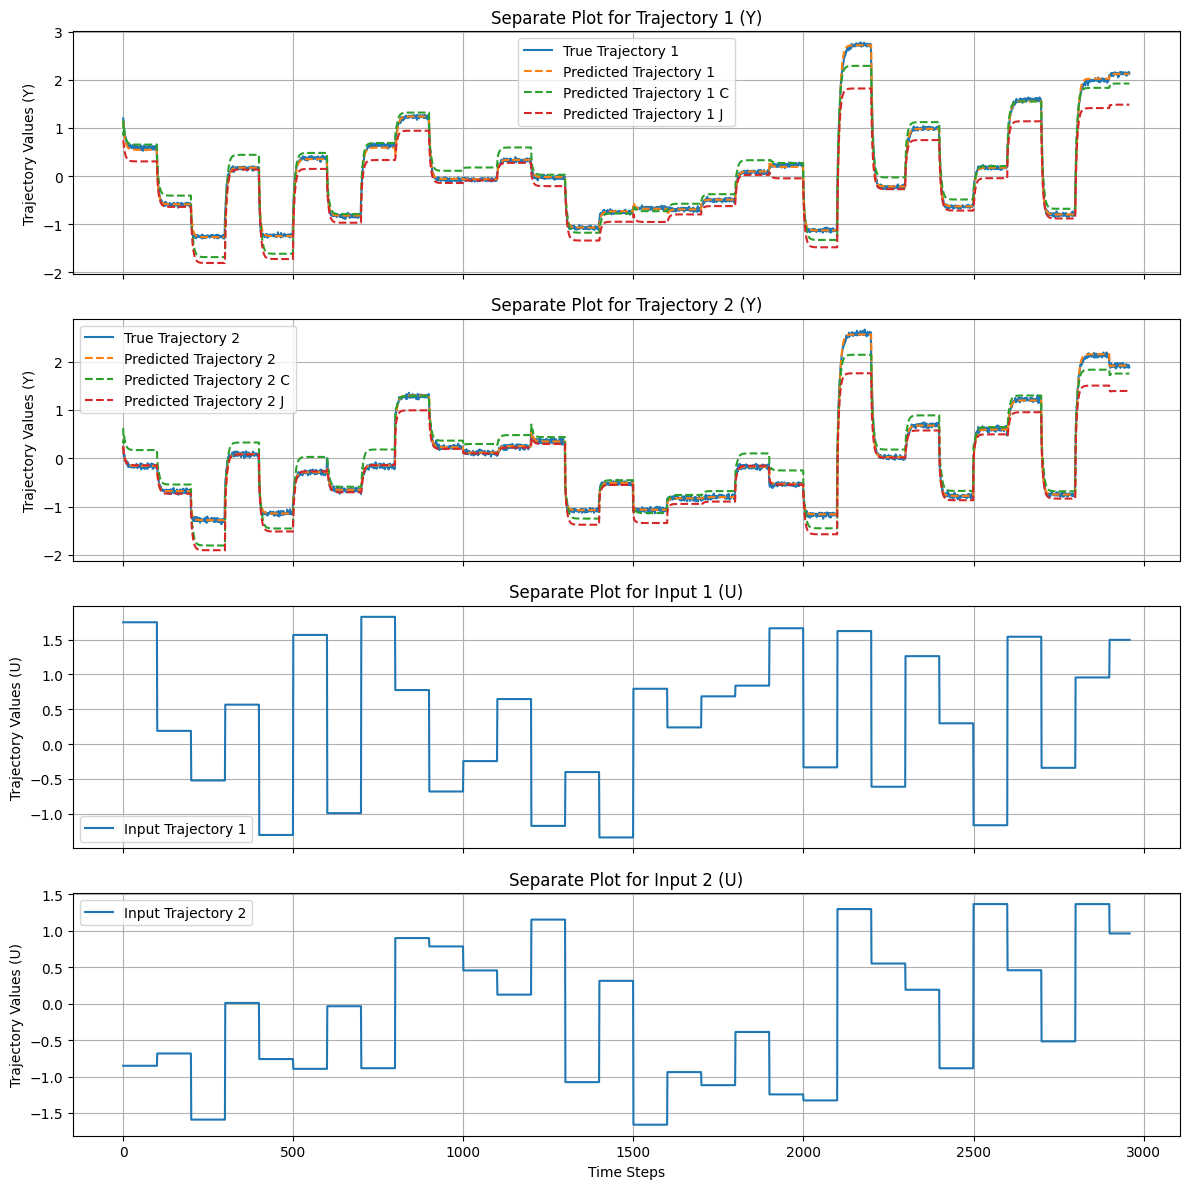

In [239]:
fig, axs = plt.subplots(ny + nu, 1, figsize=(12, 3 * (ny + nu)), sharex=True)

# Separate plots for each vector in Y
for i in range(ny):
    axs[i].plot(true_traj[i], label=f'True Trajectory {i + 1}', linestyle='-')
    axs[i].plot(pred_traj[i], label=f'Predicted Trajectory {i + 1}', linestyle='--')
    axs[i].plot(pred_traj_C[i], label=f'Predicted Trajectory {i + 1} C', linestyle='--')
    axs[i].plot(pred_traj_J[i], label=f'Predicted Trajectory {i + 1} J', linestyle='--')
    axs[i].set_title(f'Separate Plot for Trajectory {i + 1} (Y)')
    axs[i].legend()
    axs[i].grid()

# Separate plots for each vector in U
for i in range(nu):
    axs[ny + i].plot(input_traj[i], label=f'Input Trajectory {i + 1}', linestyle='-')
    axs[ny + i].set_title(f'Separate Plot for Input {i + 1} (U)')
    axs[ny + i].legend()
    axs[ny + i].grid()

# Add labels
axs[-1].set_xlabel('Time Steps')
for i in range(ny):
    axs[i].set_ylabel('Trajectory Values (Y)')
for i in range(nu):
    axs[ny + i].set_ylabel('Trajectory Values (U)')

plt.tight_layout()
plt.show()


In [240]:
# calculate MAE of predicted trajectories
mae_pred = np.mean(np.abs(true_traj - pred_traj), axis=1)
mae_pred_C = np.mean(np.abs(true_traj - pred_traj_C), axis=1)
mae_pred_J = np.mean(np.abs(true_traj - pred_traj_J), axis=1)
print(f'MAE of predicted trajectory: {mae_pred}')
print(f'MAE of predicted trajectory C: {mae_pred_C}')
print(f'MAE of predicted trajectory J: {mae_pred_J}')

MAE of predicted trajectory: [0.03172011 0.0307787 ]
MAE of predicted trajectory C: [0.15353854 0.18933187]
MAE of predicted trajectory J: [0.239351   0.17611119]


In [241]:
# Define lower and upper bounds for true_traj values
lower_bound = -0.50
upper_bound = 0.50

# Create mask for values within the specified range
mask = (true_traj >= lower_bound) & (true_traj <= upper_bound)

# Compute MAE only for masked values
mae_pred_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_C_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_C[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_J_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_J[i][mask[i]])) for i in range(true_traj.shape[0])]

print(f'Masked MAE of predicted trajectory: {mae_pred_masked}')
print(f'Masked MAE of predicted trajectory C: {mae_pred_C_masked}')
print(f'Masked MAE of predicted trajectory J: {mae_pred_J_masked}')

Masked MAE of predicted trajectory: [0.030101957, 0.03274493]
Masked MAE of predicted trajectory C: [0.16035993, 0.22348866]
Masked MAE of predicted trajectory J: [0.12571461752900298, 0.04147171775070603]


In [242]:
J_mean

array([[-0.73301876,  0.08294964, -0.35635602, -1.0201191 , -0.31184137,
        -0.29348072, -0.5064383 ,  0.51841974, -0.62888277, -0.12432393],
       [-0.01118642, -0.78524446, -0.82834196, -0.08209892, -1.4200333 ,
        -0.17782876, -1.042456  ,  1.067105  ,  0.43385088,  0.08682393]],
      dtype=float32)

In [243]:
C

array([[  3.847284  ,  -8.988227  , -13.38703   ,   8.59717   ,
          4.4546657 , -13.253162  ,  -2.5043724 ,  -2.8225346 ,
         16.661474  ,  -0.42832762],
       [  7.2290797 ,  -9.381039  , -19.80745   ,  10.620766  ,
          3.739806  , -16.696905  ,  -3.924096  ,  -3.3562856 ,
         21.69492   ,   0.5463706 ]], dtype=float32)

In [244]:
# mse C-J
mse_C_J = np.mean((C - J_mean) ** 2)
print("Mean Squared Error between C and J_mean:\n", mse_C_J)
# mse C-J
mse_C_J = np.mean((C - J) ** 2)
print("Mean Squared Error between C and J:\n", mse_C_J)

Mean Squared Error between C and J_mean:
 112.55585
Mean Squared Error between C and J:
 111.427345


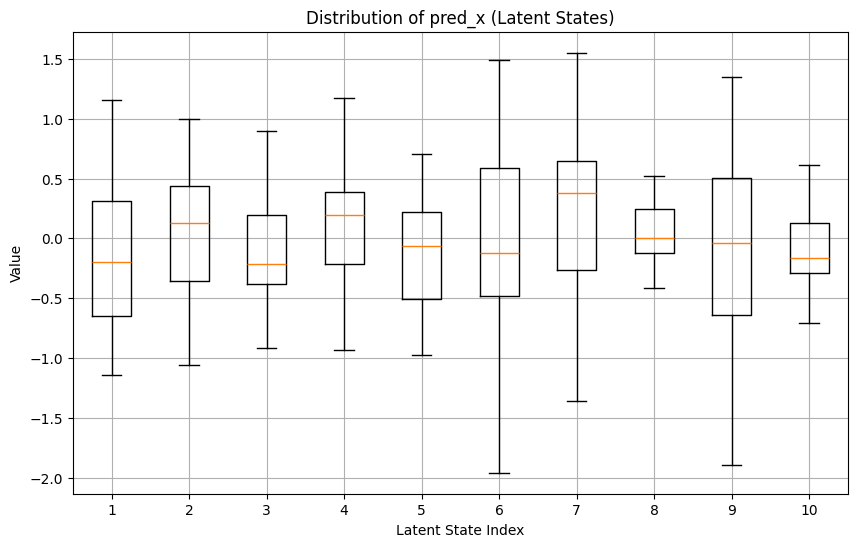

In [245]:
plt.figure(figsize=(10, 6))
plt.boxplot(pred_x.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()